In [11]:
!git clone https://github.com/christianpritz/unito_neuroAI_II.git
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Define functions to filter dataset by digits and display some of the data

In [9]:
def filter_digits(x, y, digits):
    mask = np.isin(y, digits)
    return x[mask], y[mask]

def plot_mnist_subset(x, y, num_images=16, class_names=None):
    """
    Plots a grid of MNIST images with labels.
    
    Args:
        x: np.array of images, shape (N,28,28,1)
        y: np.array of labels
        num_images: number of images to display
        class_names: optional list mapping label indices to display names
    """
    plt.figure(figsize=(8,8))
    indices = np.random.choice(len(x), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), i+1)
        plt.imshow(x[idx].squeeze(), cmap='gray')
        label = y[idx]
        if class_names is not None:
            label = class_names[label]
        plt.title(str(label))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Build the CNN for digit classification

In [3]:
def build_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the two tasks by sets of numbers

In [4]:
first_digits = [3,6,8,0]
second_digits = [1,2,7]


# Filter the dataset and display a few instance

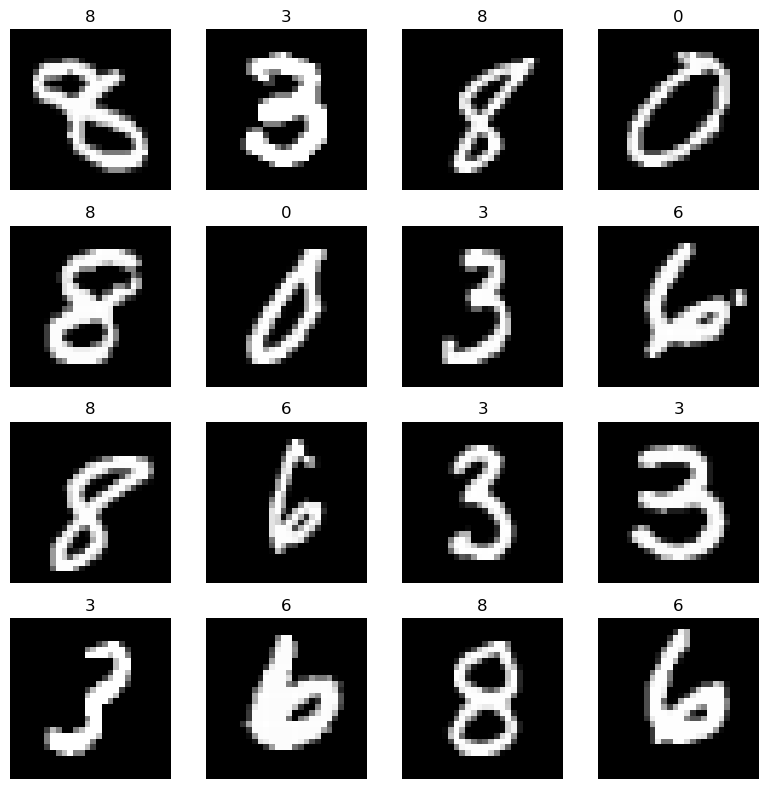

In [12]:
# Suppose you have a filtered training set
x_train1, y_train1 = filter_digits(x_train, y_train, [3,6,8,0])

# Reindex labels to 0..3
label_mapping = {3:0, 6:1, 8:2, 0:3}
y_train1_mapped = np.array([label_mapping[l] for l in y_train1])

plot_mnist_subset(x_train1, y_train1_mapped, num_images=16, class_names=['3','6','8','0'])

# Train the first task and evalute the accuracy

In [22]:
x_train1, y_train1 = filter_digits(x_train, y_train, first_digits)
x_test1, y_test1 = filter_digits(x_test, y_test, first_digits)

# Mapping the labels on the subselected dataset. 
label_mapping = {3:0, 6:1, 8:2, 0:3}
y_train1_mapped = np.array([label_mapping[l] for l in y_train1])
y_test1_mapped = np.array([label_mapping[l] for l in y_test1])


model = build_cnn(num_classes=len(first_digits))

print("Training on first subset:", first_digits)
model.fit(x_train1, y_train1_mapped, epochs=5, batch_size=64, validation_data=(x_test1, y_test1_mapped))

acc_first = model.evaluate(x_test1, y_test1_mapped, verbose=0)[1]
print('#########################################################################')
print(f"Accuracy on first subset after training: {acc_first*100:.2f}%")
print('#########################################################################')

Training on first subset: [3, 6, 8, 0]
Epoch 1/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9701 - loss: 0.0974 - val_accuracy: 0.9890 - val_loss: 0.0321
Epoch 2/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9920 - loss: 0.0232 - val_accuracy: 0.9934 - val_loss: 0.0214
Epoch 3/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9953 - loss: 0.0153 - val_accuracy: 0.9939 - val_loss: 0.0162
Epoch 4/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0126 - val_accuracy: 0.9949 - val_loss: 0.0147
Epoch 5/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9946 - val_loss: 0.0168
#########################################################################
Accuracy on first subset after training: 99.46%
#########################################################################


In [23]:
x_train2, y_train2 = filter_digits(x_train, y_train, second_digits)
x_test2, y_test2 = filter_digits(x_test, y_test, second_digits)

print(y_train2)

# Mapping the labels on the subselected dataset. 
label_mapping = {1:0, 2:1, 7:2}
y_train2_mapped = np.array([label_mapping[l] for l in y_train2])
y_test2_mapped = np.array([label_mapping[l] for l in y_test2])



# Recompile model with new number of classes
# Note: for simplicity, we rebuild the output layer
model.pop()  # remove last Dense layer
model.add(layers.Dense(len(second_digits), activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\nRetraining on second subset:", second_digits)
model.fit(x_train2, y_train2_mapped, epochs=10, batch_size=64, validation_data=(x_test2, y_test2_mapped))
print('#########################################################################')
acc_second = model.evaluate(x_test2, y_test2_mapped, verbose=0)[1]
print(f"Accuracy on second subset after training: {acc_second*100:.2f}%")

# -------------------------------
# 7. Test first subset again to show catastrophic forgetting
# -------------------------------
# Rebuild output layer to first digits temporarily for evaluation
model.pop()
model.add(layers.Dense(len(first_digits), activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


acc_first_after = model.evaluate(x_test1, y_test1_mapped, verbose=0)[1]
print('#########################################################################')
print(f"Accuracy on first subset after retraining: {acc_first_after*100:.2f}%")
print("Chance level is 25 %")

[1 2 1 ... 7 2 1]

Retraining on second subset: [1, 2, 7]
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9779 - loss: 0.0615 - val_accuracy: 0.9944 - val_loss: 0.0184
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9944 - loss: 0.0179 - val_accuracy: 0.9953 - val_loss: 0.0154
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9944 - val_loss: 0.0147
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9973 - loss: 0.0097 - val_accuracy: 0.9966 - val_loss: 0.0089
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9975 - loss: 0.0072 - val_accuracy: 0.9950 - val_loss: 0.0123
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0072 - val_accuracy: 0.9962 - val_loss: 0.0142
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 0.9941 - val_loss: 0.0143
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3m